In [1]:
import numpy as np
import matplotlib.pyplot as plt
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
from matplotlib import cm
plt.rcParams.update(newparams)
import time

In [2]:
def tridiag(v, d, w, N):
    # Help function (copied from exercise 2)
    # Returns a tridiagonal matrix A=tridiag(v, d, w) of dimension N x N.
    e = np.ones(N)        # array [1,1,...,1] of length N
    A = v*np.diag(e[1:],-1)+d*np.diag(e)+w*np.diag(e[1:],1)
    return A

In [3]:
#Initial conditions

def european_put(x):
    return np.fmax(K-x, 0)

def butterfly_spread(x):
    return np.fmax(x-K, 0) - 2*np.fmax(x-(K+H) , 0) + np.fmax(x-(K+2*H), 0)

def binary_call(x):
    if(isinstance(x, int)):
        if(x-K <0):
            return 0
        return 1
    x = x.copy()
    for i in range(len(x)):
        if(x[i]-K < 0):
            x[i] = 0
        else:
            x[i] = 1
    return x

def initial_f(K, H, x, t0):
    return np.sin(t0) + x

In [4]:
M = 10
N = 400
T = 1
sigma = 0.5
r = 0.05
c = 0.15
R = 1
K = 0.5
H = 0.5


#boundary conditions
def g0(C, c, t):
    return C*np.exp(-c*t)

def g1(t):
    return 0

#Standard RHS, f = 0
def rhs0(x, t):
    return 0

In [5]:
def forward_euler_BS(f, M = M, N = N, T = T, sigma = sigma, r = r, c = c, R = R, K = K, H = H, g0 = g0, g1 = g1, rhs = rhs0, bc = 0):
    '''
        Solves the 1D linear Black-Scholes equation with specified initial conditions and artificial B.C.
        
        Input: 
        f: Initial conditions
        M, N: number of grid intervals in x and t direction
        T: end of integration
        sigma, r, c: volatility, interest rate, dividends and correlation
        R: right boundary
        K, H: Strike prices
        g0: left BC (x = 0)
        g1: right BC (x = R)
        rhs: RHS for the scheme, standard set as 0
        bc: 0: U(R, t) = 0 (Dirichlet BC), 1: Ux(R, t) = 0, 2: Ux(R, t) = Ux(R, 0)
        
        Output:
        x, t: grid in x and t direction
        U: array with numerical solution     
    '''
    
    h = R/M                    #stepsize in space
    k = T/N                    #stepsize in time
    U = np.zeros((M+1,N+1))    # Array to store the solution, boundaries included.
    x = np.linspace(0,R,M+1)   # Gridpoints on the x-axis
    t = np.linspace(0,T,N+1)   # Gridpoints on the t-axis
    U[:,0] = f(x)        # Initial values
    
    #B.C
    C = f(0)
    U[0, :] = g0(C, c, t)
    if(bc == 0):   #U(R, t) = 0          
        U[-1, :] = g1(t)
    elif (bc == 1): #U(R, t) = U(R, 0)
        U[-1, :] = U[-1, 0]
    elif (bc == 2): #Ux(R, t) = 0
        U[-1, :] = U[-2, :] #Fuck, this does not work
    elif (bc == 3): #Ux(R, t) = Ux(R, 0)
        U[-1, :] = (U[-2, 0] - U[-1, 0])/h
    else: #same as BC = 1
        print("Assumed diriclet BC")
        U[-1, :] = g1(t)
      
    alpha = 1/2*k/h**2 *sigma**2 * x**2 - (k*r*x)/(2*h)
    beta = 1 - k/h**2 * sigma**2 * x**2 - k*c
    gamma = 1/2*k/h**2 *sigma**2 * x**2 + (k*r*x)/(2*h)
    
    A = tridiag(alpha[2:], beta[1:-1], gamma[0:-2], M-1)
    
    for n in range(N):
        q = np.zeros(M-1)
        q[0] = alpha[1]*U[0, n]
        q[-1] = gamma[M-1]*U[M, n]
        U[1:-1, n+1] = A@U[1:-1, n] + q +  k*rhs(x[1:-1], t[n])
        if(bc == 2):
            U[-1, n] = U[-2, n]
    if (bc == 2): #Ux(R, t) = 0
        U[-1, :] = U[-2, :] #Fuck, this does not work
    return x, t, U

def backward_euler_BS(f, M = M, N = N, T = T, sigma = sigma, r = r, c = c, R = R, K = K, H = H, g0 = g0, g1 = g1, rhs = rhs0):
    '''
        Same input/output as forward_euler_BS
    '''
    
    h = R/M                    #stepsize in space
    k = T/N                    #stepsize in time
    U = np.zeros((M+1,N+1))    # Array to store the solution, boundaries included.
    x = np.linspace(0,R,M+1)   # Gridpoints on the x-axis
    t = np.linspace(0,T,N+1)   # Gridpoints on the t-axis
    U[:,0] = f(x)        # Initial values
    
    #B.C
    C = f(0)
    U[0, :] = g0(C, c, t)             
    U[-1, :] = g1(t)
    
    alpha = 1/2 * (k*sigma**2*x**2)/h**2 - (r*k*x)/(2*h)
    beta = 1 + (k*sigma**2*x**2)/h**2 + c*k
    gamma = 1/2 * (k*sigma**2*x**2)/h**2 + (r*k*x)/(2*h)
    
    A = tridiag(-alpha[2:], beta[1:-1], -gamma[0:-2], M-1)
    for n in range(N):
        q = np.zeros(M-1)
        q[0] = alpha[1]*U[0, n]
        q[-1] = gamma[M-1]*U[M, n]
        U[1:-1, n+1] = np.linalg.solve(A, U[1:-1, n] + q + k*rhs(x[1:-1], t[n]))
    return x, t, U

def crank_Nicolson_BS(f, M = M, N = N, T = T, sigma = sigma, r = r, c = c, R = R, K = K, H = H, g0 = g0, g1 = g1, rhs = rhs0):
    '''
    Same input/output as above functions
    '''
    
    h = R/M                    #stepsize in space
    k = T/N                    #stepsize in time
    U = np.zeros((M+1,N+1))    # Array to store the solution, boundaries included.
    x = np.linspace(0,R,M+1)   # Gridpoints on the x-axis
    t = np.linspace(0,T,N+1)   # Gridpoints on the t-axis
    U[:,0] = f(x)        # Initial values
    
    #B.C
    C = f(0)
    U[0, :] = g0(C, c, t)             
    U[-1, :] = g1(t)
    
    a = 1/2 * (sigma**2 * x**2 * k)/h**2
    b = (r*x*k)/(2*h)
    
    alpha = 1/2*a - 1/2*b
    beta = a + (c*k)/2
    gamma = 1/2*(a+b)
    
    A = tridiag(-alpha[2:], (1+beta[1:-1]), -gamma[0:-2], M-1)
    B = tridiag(alpha[2:], (1-beta[1:-1]), gamma[0:-2], M-1)
    
    for n in range(N):
        q = np.zeros(M-1)
        q[0] = alpha[1]*U[0, n]
        q[-1] = gamma[M-1]*U[M, n]
        U[1:-1, n+1] = np.linalg.solve(A, (B@U[1:-1, n] + q + k/2*(rhs(x[1:-1], t[n]) + rhs(x[1:-1], t[n+1]))))
    return x, t, U

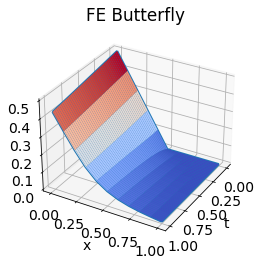

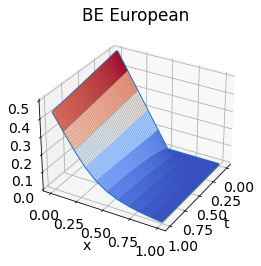

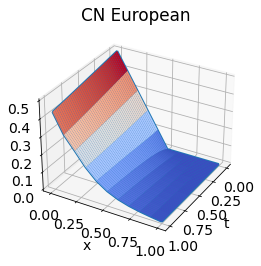

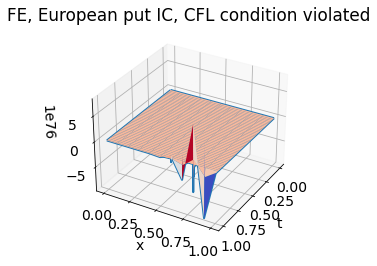

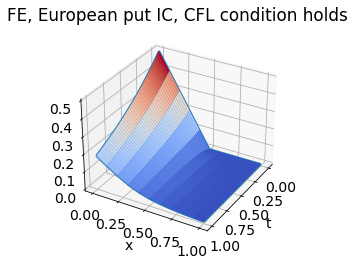

In [6]:
def plot_solution(x, t, U, txt='Solution'):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    T, X = np.meshgrid(t,x)
    ax.plot_wireframe(T, X, U)
    ax.plot_surface(T, X, U, cmap=cm.coolwarm)
    ax.view_init(azim=30)              # Rotate the figure
    plt.xlabel('t')
    plt.ylabel('x')
    plt.title(txt);


x, t, U = forward_euler_BS(european_put)

x1, t1, U1 = backward_euler_BS(european_put)
x2, t2, U2 = crank_Nicolson_BS(european_put)
plot_solution(x, t, U, txt = "FE Butterfly")
plot_solution(x1, t1, U1, txt = "BE European")
plot_solution(x2, t2, U2, txt = "CN European")


x, t, U = forward_euler_BS(european_put, c = 1, sigma = 3)
x1, t1, U1 = forward_euler_BS(european_put, c = 1)
plot_solution(x, t, U, txt = "FE, European put IC, CFL condition violated")
plot_solution(x1, t1, U1, txt = "FE, European put IC, CFL condition holds")

In [7]:
#IC for f(x) = x^3 + 2t^2
def f1(x):
    return  x**3

#Test function: f(x) = x^3 + 2t^2
def uexact(x,t):  
    return x**3 + 2*t**2

#rhs for f(x) = x^2 + 2t^2
def rhs_(x,t):
    return 4*t - 3*sigma**2*x**3 - 3*r*x**3 + c*(x**3 + 2*t**2)

#Left BC for f(x) = x^3 + 2t^2
def lb(C, c, t):
    return 2*t**2

#Right BC for f(x) = x^3 + 2t^2
def rb(t):
    return 2*t**2 + 1**3

#rhs for exact solution e^-t sin(pi x)
def rhs_ugly(x, t):
    a = -np.exp(-t)*np.sin(np.pi*x) + 1/2*sigma**2*x**2 * (np.pi**2*np.exp(-t)*np.sin(np.pi*x))\
    -r*x*np.pi*np.exp(-t)*np.cos(np.pi*x) + c*np.exp(-t)*np.sin(np.pi*x)
    return a

#IC for e^-t sin(pi x)
def f_ugly(x):
    return np.sin(np.pi*x)

# Exact solution: e^-tsin(pi x)
def uexact_ugly(x,t):  
    return np.exp(-t)*np.sin(np.pi*x)

#Right BC for e^-t sin(pi x)
def rb_ugly(t):
    return 0

#Left BC for e^-t sin(pi x)
def lb_ugly(C, c, t):
    return 0

In [8]:
def convergence(u_exact, solver=forward_euler_BS, f=f1, g0 = g0, g1 = g1, rhs = rhs0): 
    P = 6
    Hconv = np.zeros(P)
    Econv = np.zeros(P)
    M = 2
    for p in range(P):
        x, t, U = solver(f, M=M, N=10000, T=1, g0 = g0, g1 = g1, rhs = rhs)
        Eh = u_exact(x,t[-1])-U[:,-1]
        Hconv[p] = (x[1]-x[0])
        Econv[p] = np.max(np.abs(Eh))
        M = 2*M
    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]
    return Hconv, Econv, order

In [9]:
xref, tref, UrefFE = forward_euler_BS(f_ugly, M = M, N = 100000, g0 = lb_ugly, g1 = rb_ugly, rhs = rhs_ugly)
xref, tref, UrefBE = backward_euler_BS(f_ugly, M = M, N = 100000, g0 = lb_ugly, g1 = rb_ugly, rhs = rhs_ugly)
xref, tref, UrefCN = crank_Nicolson_BS(f_ugly, M = M, N = 100000, g0 = lb_ugly, g1 = rb_ugly, rhs = rhs_ugly)

def convergence1(U_ref = UrefFE, solver=forward_euler_BS, f=f1, g0 = g0, g1 = g1, rhs = rhs0): 
    P = 6
    Tconv = np.zeros(P)
    Econv = np.zeros(P)
    N = 400
    for p in range(P):
        x, t, U = solver(f, M=M, N=N, g0 = g0, g1 = g1, rhs = rhs, c = c, sigma = sigma, r = r)
        Eh = U_ref[:, -1]-U[:,-1]
        Tconv[p] = (t[1]-t[0])
        Econv[p] = np.max(np.abs(Eh))
        N = 2*N
    order = np.polyfit(np.log(Tconv),np.log(Econv),1)[0]
    return Tconv, Econv, order

1.9330789887684687
2.085559360421017
1.9090957894505858


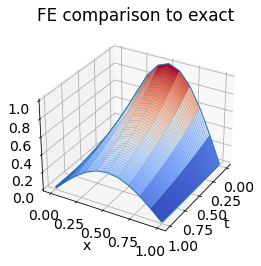

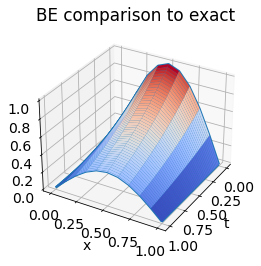

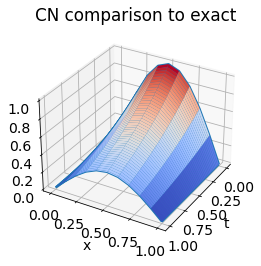

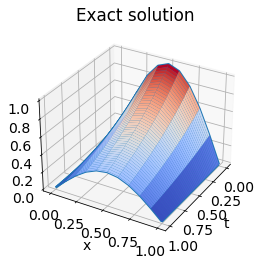

In [10]:
xtestFE, ttestFE, UtestFE = forward_euler_BS(f_ugly, g0 = lb_ugly, g1 = rb_ugly, rhs = rhs_ugly)

xtestBE, ttestBE, UtestBE = backward_euler_BS(f_ugly, g0 = lb_ugly, g1 = rb_ugly, rhs = rhs_ugly)

xtestCN, ttestCN, UtestCN = crank_Nicolson_BS(f_ugly, g0 = lb_ugly, g1 = rb_ugly, rhs = rhs_ugly)



plot_solution(xtestFE, ttestFE, UtestFE, "FE comparison to exact")
plot_solution(xtestBE, ttestBE, UtestBE, "BE comparison to exact")
plot_solution(xtestCN, ttestCN, UtestCN, "CN comparison to exact")

U = np.zeros((M+1,N+1))    # Array to store the solution, boundaries included.
x = np.linspace(0,1,M+1)   # Gridpoints on the x-axis
t = np.linspace(0,1,N+1)

for n in range(N+1):
    U[:, n] = uexact_ugly(x, t[n]) 
    
plot_solution(x, t, U, txt = "Exact solution")


H_FE, E_FE, order_FE = convergence(uexact_ugly, solver=forward_euler_BS, f=f_ugly, g0 = lb_ugly, g1 = rb_ugly, rhs = rhs_ugly)
H_BE, E_BE, order_BE = convergence(uexact_ugly, solver=backward_euler_BS, f=f_ugly, g0 = lb_ugly, g1 = rb_ugly, rhs = rhs_ugly)
H_CN, E_CN, order_CN = convergence(uexact_ugly, solver=crank_Nicolson_BS, f=f_ugly, g0 = lb_ugly, g1 = rb_ugly, rhs = rhs_ugly)

print(order_CN)
print(order_FE)
print(order_BE)

In [11]:
time_startFE = time.perf_counter()
for i in range(100):
    xtestFE, ttestFE, UtestFE = forward_euler_BS(f_ugly, g0 = lb_ugly, g1 = rb_ugly, rhs = rhs_ugly)
time_elapsedFE = (time.perf_counter() - time_startFE)
print("Computational time for FE: ", time_elapsedFE)
time_startBE = time.perf_counter()
for i in range(100):
    xtestBE, ttestBE, UtestBE = backward_euler_BS(f_ugly, g0 = lb_ugly, g1 = rb_ugly, rhs = rhs_ugly)
time_elapsedBE = (time.perf_counter() - time_startBE)
print("Computational time for BE: ", time_elapsedBE)
time_startCN = time.perf_counter()
for i in range(100):
    xtestCN, ttestCN, UtestCN = crank_Nicolson_BS(f_ugly, g0 = lb_ugly, g1 = rb_ugly, rhs = rhs_ugly)
time_elapsedCN = (time.perf_counter() - time_startCN)
print("Computational time for CN: ", time_elapsedCN)

Computational time for FE:  2.3849745340000013
Computational time for BE:  2.058929327999998
Computational time for CN:  3.168238690999999


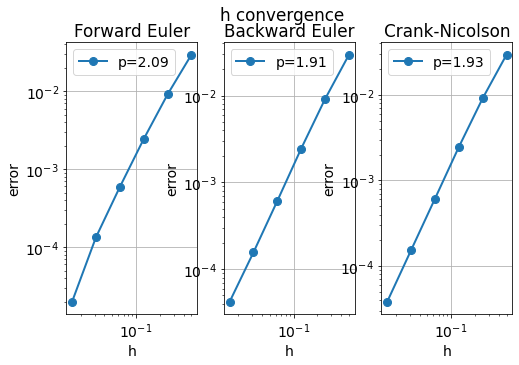

In [12]:
fig = plt.figure(figsize = (8, 5))
fig.suptitle("h convergence")

ax1 = fig.add_subplot(1, 3, 1)
ax1.loglog(H_FE, E_FE, 'o-', label = 'p={:.2f}'.format(order_FE))
ax1.set_xlabel('h')
ax1.set_ylabel('error')
ax1.set_title("Forward Euler")
ax1.legend()

ax2 = fig.add_subplot(1, 3, 2)
ax2.loglog(H_BE, E_BE, 'o-', label = 'p={:.2f}'.format(order_BE))
ax2.set_xlabel('h')
ax2.set_ylabel('error')
ax2.set_title("Backward Euler")
ax2.legend()

ax3 = fig.add_subplot(1, 3, 3)
ax3.loglog(H_CN, E_CN, 'o-', label = 'p={:.2f}'.format(order_CN))
ax3.set_xlabel('h')
ax3.set_ylabel('error')
ax3.set_title("Crank-Nicolson")
ax3.legend()

In [13]:
T_FE, E_FE, p_FE = convergence1(UrefFE, solver=forward_euler_BS, f=f_ugly, g0 = lb_ugly, g1 = rb_ugly, rhs = rhs_ugly)
T_BE, E_BE, p_BE = convergence1(UrefBE, solver=backward_euler_BS, f=f_ugly, g0 = lb_ugly, g1 = rb_ugly, rhs = rhs_ugly)
T_CN, E_CN, p_CN = convergence1(UrefCN, solver=crank_Nicolson_BS, f=f_ugly, g0 = lb_ugly, g1 = rb_ugly, rhs = rhs_ugly)

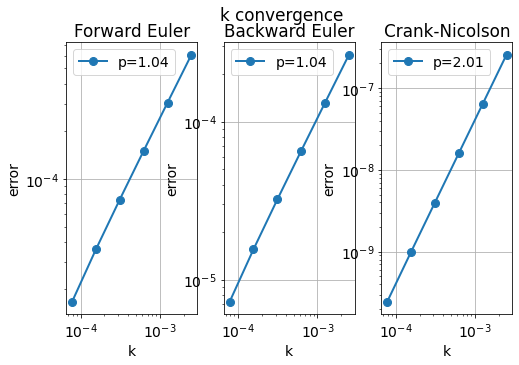

In [14]:
fig = plt.figure(figsize = (8, 5))
fig.suptitle("k convergence")

ax1 = fig.add_subplot(1, 3, 1)
ax1.loglog(T_FE, E_FE, 'o-', label = 'p={:.2f}'.format(p_FE))
ax1.set_xlabel('k')
ax1.set_ylabel('error')
ax1.set_title("Forward Euler")
ax1.legend()

ax2 = fig.add_subplot(1, 3, 2)
ax2.loglog(T_BE, E_BE, 'o-', label = 'p={:.2f}'.format(p_BE))
ax2.set_xlabel('k')
ax2.set_ylabel('error')
ax2.set_title("Backward Euler")
ax2.legend()

ax3 = fig.add_subplot(1, 3, 3)
ax3.loglog(T_CN, E_CN, 'o-', label = 'p={:.2f}'.format(p_CN))
ax3.set_xlabel('k')
ax3.set_ylabel('error')
ax3.set_title("Crank-Nicolson")
ax3.legend()

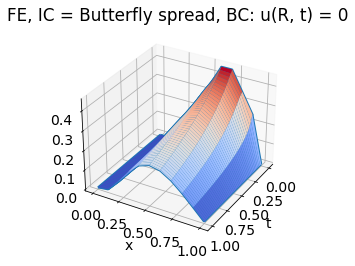

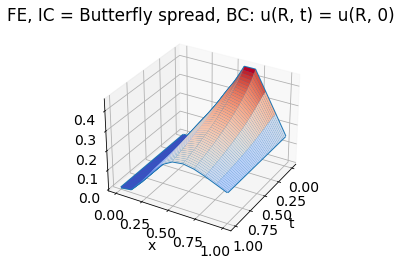

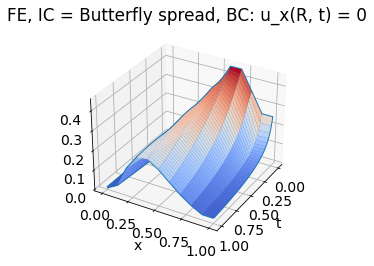

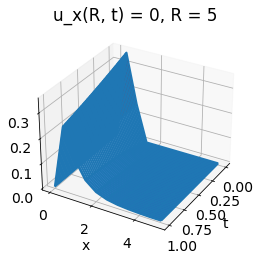

In [15]:
#Neumann BC
K = 0.15
ic = butterfly_spread
x, t, U = forward_euler_BS(ic)
plot_solution(x, t, U, txt = "FE, IC = Butterfly spread, BC: u(R, t) = 0")
xNeu, tNeu, UNeu = forward_euler_BS(ic, bc = 1, K = 1, H = 1)
plot_solution(xNeu, tNeu, UNeu, txt = "FE, IC = Butterfly spread, BC: u(R, t) = u(R, 0)")
xNeu1, tNeu1, UNeu1 = forward_euler_BS(ic, bc = 2, r = 0.5)
plot_solution(xNeu1, tNeu1, UNeu1, txt = "FE, IC = Butterfly spread, BC: u_x(R, t) = 0")
xNeu2, tNeu2, UNeu2 = forward_euler_BS(ic, bc = 2, R = 5)
plot_solution(xNeu2, tNeu2, UNeu2, txt = "u_x(R, t) = 0, R = 5")

In [16]:
#Program to see the effects of increasing R

for i in range(1, 15):
    R_ = i
    x, t, numSol = forward_euler_BS(f1, g0=lb, rhs = rhs_, bc = 3, R = R_)
    T, X = np.meshgrid(t, x)
    U_exact = uexact(X, T)
    error = np.amax(U_exact - numSol)
    print("R = ", R_, "error = ", error)

R =  1 error =  5.709999999999999
R =  2 error =  20.839999999999996
R =  3 error =  53.39000000000003
R =  4 error =  109.35999999999999
R =  5 error =  194.75
R =  6 error =  315.5600000000001
R =  7 error =  477.7900000000001
R =  8 error =  687.4399999999999
R =  9 error =  950.5100000000001
R =  10 error =  1273.0
R =  11 error =  1660.9099999999999
R =  12 error =  2120.2400000000002
R =  13 error =  2656.99
R =  14 error =  3277.1600000000003


In [17]:
def phi(sigma_1, sigma_2, U, h): #Makes sure that U is of type float
    """
    Calculates a Phi vector with the central differences
    """
    b = np.zeros_like(U); a = sigma_1**2 + ((sigma_2**2 - sigma_1**2)/2)
    b[1: -1] = a*(1 + ((2/np.pi)*np.arctan((1/h**2)*(U[0:-2] - 2*U[1:-1] + U[2:]))))
    return b

def phi_x(sigma_1, sigma_2, U, h):
    """
    Calculates a vector with the given x acording to a exact function
    """
    b = np.zeros_like(U); a = sigma_1**2 + ((sigma_2**2 - sigma_1**2)/2)
    return(a*(1 + (2/np.pi)*np.arctan(U)))

def off_diagonal(Phi, x, h, k):
    """
    Calculates the off diagonals for a tridiagonal matrix
    """
    return(-(k*Phi*x**2)/(2*h**2))

def diagonal(Phi, x, h, k):
    """
    Calculates the diagonals for a tridiagonal matrix
    """
    return(1 - (2*off_diagonal(Phi, x, h, k)))

In [18]:
def f(x, t, sigma_1, sigma_2, U, h):
    """
    The RHS of the excat function we want to model with the IMEX method
    """
    b = np.ones_like(x)
    a = b * np.cos(t)
    a[0] = 0; a[-1] = 0
    return(a)

In [19]:
def IMEX(initial_conditions=butterfly_spread, exact_sol = 0, M = 100, N = 5000, R_0 = 0, R_M = 1, T_0 = 0, 
         T_N = 1, sigma_1 = 0.9, sigma_2 = 1, K = 0.5, H = 0.5):
    
    h = (R_M - R_0)/M                           #stepsize in space
    k = (T_N - T_0)/N                           #stepsize in time
    U = np.zeros((N+1, M+1))                    # Array to store the solution, boundaries included.
    x = np.linspace(R_0, R_M, M+1)              # Gridpoints on the x-axis
    t = np.linspace(T_0, T_N, N+1)              # Gridpoints on the t-axis
    
    #Setting initual values 
    if(initial_conditions == butterfly_spread):
        U[0, :] = butterfly_spread(x)
    else:
        U[0, :] = initial_conditions(K, H, x, T_0)

    #B.C
    if(initial_conditions == initial_f):
        U[:, 0] = initial_f(K, H, R_0, t)              
        U[:, -1] = initial_f(K, H, R_M, t)
    else:
        U[:, 0] = U[0,0]
        U[:, -1] = U[0, -1]
    
    for n in range(N):
        Phi = phi(sigma_1, sigma_2, U[n, ], h)
        A = off_diagonal(Phi, x, h, k)
        C = diagonal(Phi, x, h, k)

        matrix = np.diag(C) + np.diag(A[:-1], 1) + np.diag(A[1:], -1)

        a, b = U[n+1, 0], U[n+1, -1]
        matrix_inv = np.linalg.inv(matrix)
        if(exact_sol == 0):
            U[n+1, :] = matrix_inv@(U[n, :])
        else:
            U[n+1, :] = matrix_inv@(U[n, :] + k*exact_sol(x, t[n], sigma_1, sigma_2, x, h))
        U[n+1, 0], U[n+1, -1] = a, b

    return x, t, U    

In [20]:
x, t, U = IMEX(initial_conditions=initial_f, exact_sol=f, R_M = 2, T_N = 2)
X, T = np.meshgrid(x, t)
Y = initial_f(0.5, 0.5, X, T)

Text(0.5, 0.92, 'Analytical')

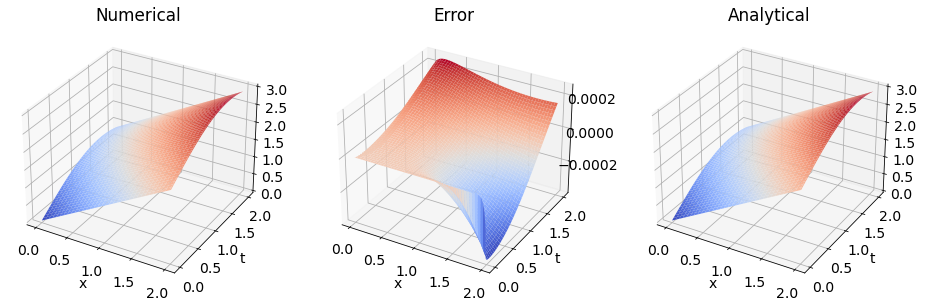

In [21]:
fig = plt.figure(figsize=(16, 10))    #Create figure

ax = fig.add_subplot(1, 3, 1, projection="3d") 
ax.plot_surface(X, T, U, cmap=cm.coolwarm)
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_title("Numerical")

ax2 = fig.add_subplot(1, 3, 2, projection="3d")
ax2.plot_surface(X[1:-1, 1:-1], T[1:-1, 1:-1], (U-Y)[1:-1, 1:-1], cmap=cm.coolwarm)
ax2.set_xlabel("x")
ax2.set_ylabel("t")
ax2.set_title("Error")

ax3 = fig.add_subplot(1, 3, 3, projection="3d")
ax3.plot_surface(X, T, Y, cmap=cm.coolwarm)
ax3.set_xlabel("x")
ax3.set_ylabel("t")
ax3.set_title("Analytical")

Text(0.5, 0.92, 'Butterfly spread')

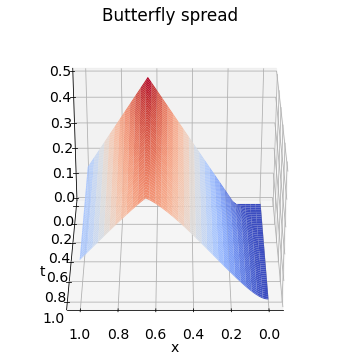

In [22]:
x, t, U = IMEX()
X, T = np.meshgrid(x, t)
fig = plt.figure(figsize=(18, 6))    #Create figure 
ax = fig.add_subplot(1, 1, 1, projection="3d") 
ax.plot_surface(X, T, U, cmap=cm.coolwarm)
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.view_init(azim=90)
ax.set_title("Butterfly spread")